<a href="https://colab.research.google.com/gist/afiaka87/57014336b29dde8e100a171350c22968/clip-guided-diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generates images from text prompts with CLIP guided diffusion.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses OpenAI's 256x256 unconditional ImageNet diffusion model (https://github.com/openai/guided-diffusion) together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images. 

In [16]:
# Check the GPU status

# !nvidia-smi

In [17]:
# Install dependencies
from IPython.display import clear_output
%rm -rf '/tmp/CLIP'
%rm -rf '/tmp/guided_diffusion'

!git clone 'https://github.com/openai/CLIP' '/tmp/CLIP'
!git clone 'https://github.com/openai/guided-diffusion' '/tmp/guided-diffusion'

%mv '/tmp/CLIP' './CLIP'
%mv '/tmp/guided-diffusion' './guided-diffusion'

%pip install -e './CLIP'
%pip install -e './guided_diffusion'
%pip install kornia

# clear_output()




Cloning into '/tmp/CLIP'...


In [ ]:
# Download the diffusion model

!wget --continue 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt' -O '256x256_diffusion_uncond.pt'


--2021-07-20 20:53:36--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.150.77.132
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.150.77.132|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [ ]:
import math
import sys

from IPython import display
from kornia import augmentation, filters
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
# Model settings

model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': False,
    'timestep_respacing': '500',
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

clear_output()

In [ ]:
# Load models and define necessary functions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.eval().requires_grad_(False).to(device)
model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

clear_output()

## Settings for this run:

In [ ]:
prompt = 'the letters b a t b o t'
batch_size = 4
clip_guidance_scale = 2750
seed = 0

### Actually do the run...

  0%|          | 0/500 [00:00<?, ?it/s]


Step 0, output 0:


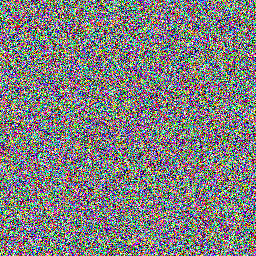

Step 0, output 1:


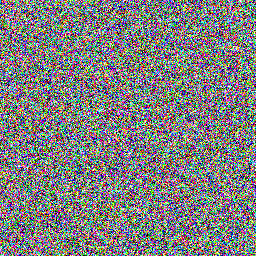

Step 0, output 2:


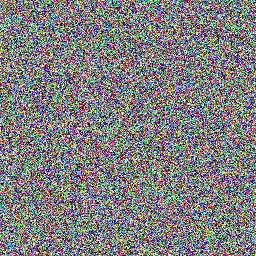

Step 0, output 3:


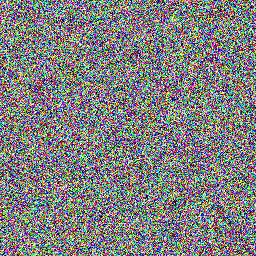


Step 100, output 0:


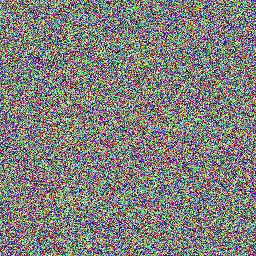

Step 100, output 1:


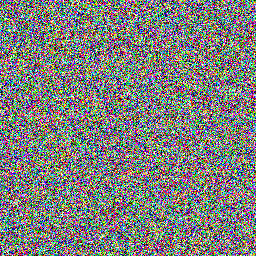

Step 100, output 2:


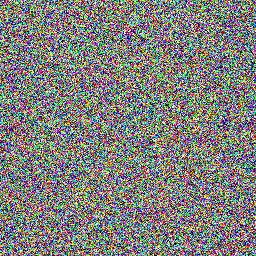

Step 100, output 3:


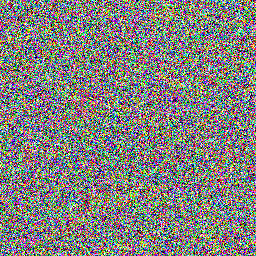


Step 200, output 0:


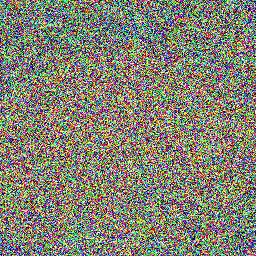

Step 200, output 1:


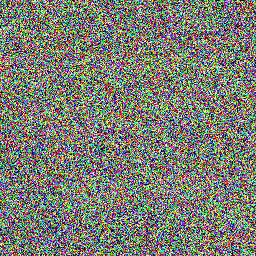

Step 200, output 2:


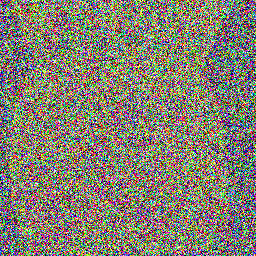

Step 200, output 3:


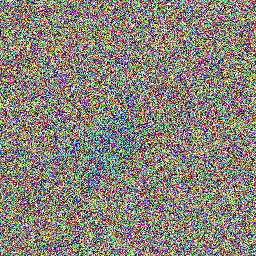


Step 300, output 0:


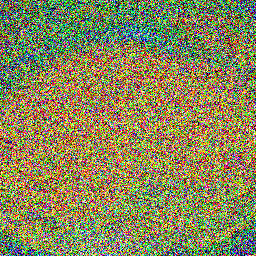

Step 300, output 1:


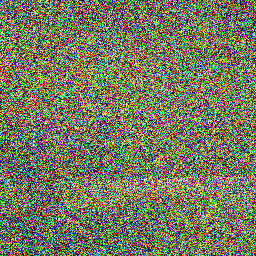

Step 300, output 2:


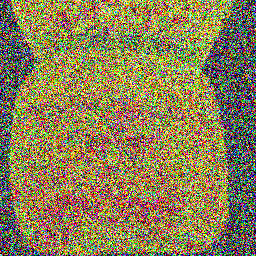

Step 300, output 3:


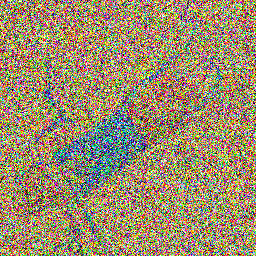


Step 400, output 0:


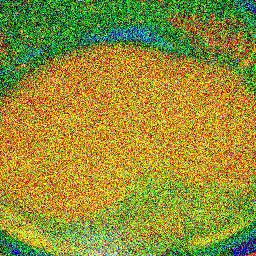

Step 400, output 1:


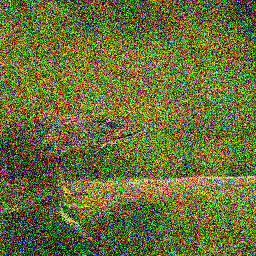

Step 400, output 2:


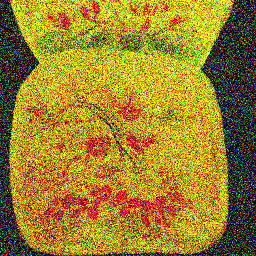

Step 400, output 3:


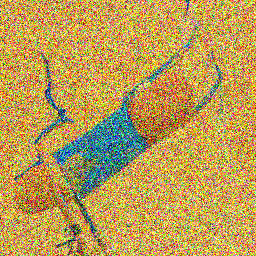


Step 499, output 0:


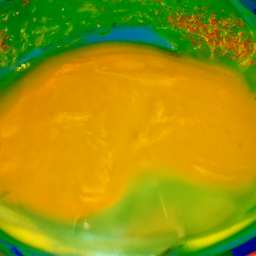

Step 499, output 1:


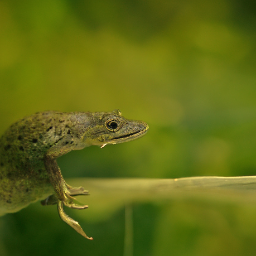

Step 499, output 2:


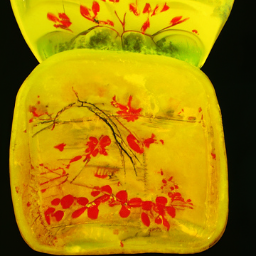

Step 499, output 3:


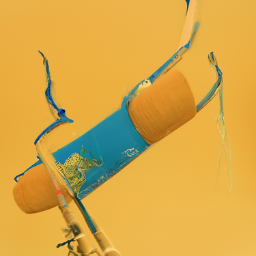

In [ ]:
from torchvision import transforms
if seed is not None:
    torch.manual_seed(seed)

text_embed = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

sigmas = 0.25 * diffusion.sqrt_one_minus_alphas_cumprod / diffusion.sqrt_alphas_cumprod
translate_by = 8 / clip_size
augmentations_list = [
    # transforms.RandomResizedCrop(64, scale=(0.5, 1.), interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.RandomSolarize(threshold=32, p=0.1),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
    transforms.RandomAutocontrast(p=0.1),
    # transforms.RandomErasing(p=0.1, scale=(0.5, 1.)),
]
if translate_by:
    augmentations_list.append(augmentation.RandomAffine(0, (translate_by, translate_by), padding_mode='border', p=1))

aug = transforms.Compose(augmentations_list)
cur_t = diffusion.num_timesteps - 1

def cond_fn(x, t, y=None):
    with torch.enable_grad():
        x_in = x.detach().requires_grad_()
        n = x_in.shape[0]
        sigma = min(24, sigmas[cur_t])
        kernel_size = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        x_blur = filters.gaussian_blur2d(x_in, (kernel_size, kernel_size), (sigma, sigma))
        clip_in = F.interpolate(aug(x_blur.add(1).div(2)), (clip_size, clip_size),
                                mode='bilinear', align_corners=False)
        image_embed = clip_model.encode_image(normalize(clip_in)).float()
        losses = spherical_dist_loss(image_embed, text_embed)
        grad = -torch.autograd.grad(losses.sum(), x_in)[0]
        return grad * clip_guidance_scale

samples = diffusion.p_sample_loop_progressive(
    model,
    (batch_size, 3, model_config['image_size'], model_config['image_size']), # 3 for RGB
    clip_denoised=True,
    model_kwargs={},
    cond_fn=cond_fn,
    progress=True,
)

for i, sample in enumerate(samples):
    cur_t -= 1
    if i % 100 == 0 or cur_t == -1:
        print()
        for j, image in enumerate(sample['sample']):
            filename = f'progress_{j:05}.png'
            TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
            tqdm.write(f'Step {i}, output {j}:')
            display.display(display.Image(filename))


In [ ]:
# @title Licensed under the MIT License
# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.